# INM706 Coursework
## Disease Prognosis Prediction using Longitudinal Electronic Health Records and Gated Recurrent Units
### Aaron Mir (Student Number: 160001207)

MIMIC-III is a large, freely-available database comprising deidentified health-related data associated with over 40,000 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The MIMIC-III Clinical Database is available on PhysioNet (doi: 10.13026/C2XW26). Though deidentified, MIMIC-III contains detailed information regarding the care of real patients, and as such requires credentialing before access. 

Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID.
Each row of this table contains a unique HADM_ID, which represents a single patient’s admission to the hospital. HADM_ID ranges from 1000000 - 1999999. It is possible for this table to have duplicate SUBJECT_ID, indicating that a single patient had multiple admissions to the hospital. The ADMISSIONS table can be linked to the PATIENTS table using SUBJECT_ID.
https://mimic.physionet.org/mimictables/admissions/ - info about admissions table

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

## Exploratory Analysis of Data
### Admissions Table

In [2]:
admission_data = pd.read_csv('data\\ADMISSIONS.csv')

In [3]:
admission_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


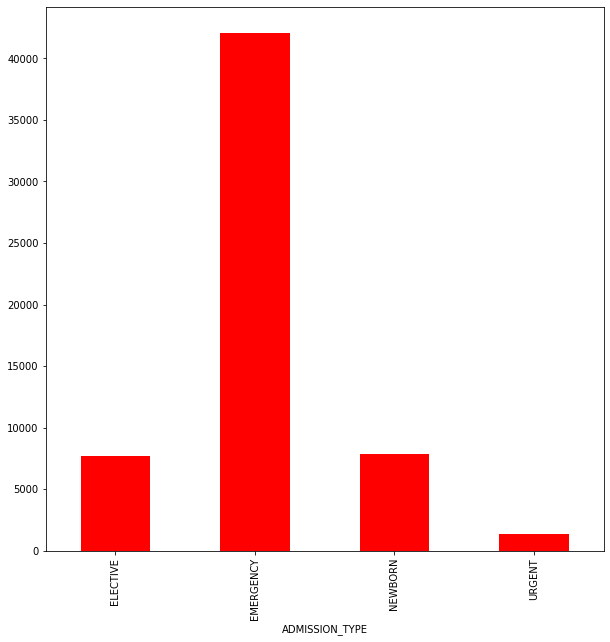

In [4]:
fig = plt.figure(figsize=(10,10))
admission_data.groupby(['ADMISSION_TYPE']).size().plot.bar(color = 'red');

In [5]:
admission_data.ADMITTIME = pd.to_datetime(admission_data.ADMITTIME, format = '%Y-%m-%d %H:%M:%S')
admission_data.DISCHTIME = pd.to_datetime(admission_data.DISCHTIME, format = '%Y-%m-%d %H:%M:%S')
admission_data.DEATHTIME = pd.to_datetime(admission_data.DEATHTIME, format = '%Y-%m-%d %H:%M:%S')

In [6]:
admission_data = admission_data.sort_values(['SUBJECT_ID','ADMITTIME'])
admission_data = admission_data.reset_index(drop = True)

In [7]:
admission_data.loc[admission_data.SUBJECT_ID  == 801, ['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY


In [8]:
admission_data['NEXT_ADMITTIME'] = admission_data.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admission_data['NEXT_ADMISSION_TYPE'] = admission_data.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [9]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaT,NaN


In [10]:
rows = admission_data.NEXT_ADMISSION_TYPE == 'ELECTIVE'
admission_data.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
admission_data.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [11]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaT,NaN


In [16]:
admission_data = admission_data.sort_values(['SUBJECT_ID','ADMITTIME'])

In [17]:
admission_data.loc[admission_data.SUBJECT_ID == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
987,801,2197-06-19 19:47:00,EMERGENCY,2197-08-09 21:00:00,EMERGENCY
988,801,2197-08-09 21:00:00,EMERGENCY,2198-07-09 23:22:00,EMERGENCY
989,801,2198-07-09 23:22:00,EMERGENCY,NaT,NaN


In [18]:
admission_data[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admission_data.groupby(['SUBJECT_ID'])\
[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [38]:
admission_data.loc[admission_data.subject_id == 801,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,subject_id,admittime,admission_type,next_admittime,next_admission_type
122,44083,2112-05-04 08:00:00,ELECTIVE,2112-05-22 15:37:00,EMERGENCY
123,44083,2112-05-22 15:37:00,EMERGENCY,2112-05-28 15:45:00,EMERGENCY
124,44083,2112-05-28 15:45:00,EMERGENCY,NaT,NaN


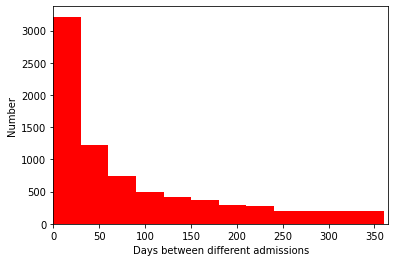

In [19]:
fig = plt.figure() 
admission_data['DAYS_NEXT_ADMIT'] = (admission_data.NEXT_ADMITTIME - admission_data.DISCHTIME).dt.total_seconds()/(24*60*60)
plt.hist(admission_data.loc[~admission_data.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins = range(0,365,30), color = 'red')
plt.xlim([0,365])
plt.xlabel('Days between different admissions')
plt.ylabel('Number')
plt.show()

### Notes Table

In [20]:
notes_data = pd.read_csv('data\\NOTEEVENTS.csv')

C:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
notes_data.head() # empty for the demo dataset

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


### Diagnosis Code Table

In [22]:
diagnosis_code_data = pd.read_csv('data\\DIAGNOSES_ICD.csv')

In [23]:
diagnosis_code_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


### Diagnosis Table

In [24]:
diagnosis_data = pd.read_csv('data\\D_ICD_DIAGNOSES.csv')

In [25]:
diagnosis_data.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


### Patients Table

In [26]:
patient_data = pd.read_csv('data\\PATIENTS.csv')

In [27]:
patient_data.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [28]:
print(f"Total Patients: {len(patient_data)}")
print(f"Number of Males: {len(patient_data[patient_data['GENDER'] == 'M'])}")
print(f"Number of Females: {len(patient_data[patient_data['GENDER'] == 'F'])}")

Total Patients: 46520
Number of Males: 26121
Number of Females: 20399


C:\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


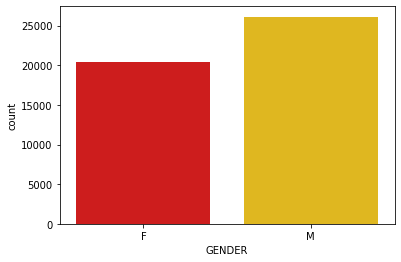

In [29]:
sns.countplot(patient_data['GENDER'], palette="hot")
plt.show()

## Data pre-processing#

Checklist

    1. Extract hadm_id, subject_id_ admittime, dischtime, icd9_code, description_of_code (long_title) and create new table
    2. Map the subject_id with the hadm_id and the admittime to match a patient to specific visits
    3. Map the hadm_id to each icd9_code assigned during the visit
    4. Add each code assigned to the patient directing into the dictionary with the patient-admission id mapping and the visit date mapping . Which allows us to have a list of list of icd9_code's that each patient recieved during each visit

## Training

In [50]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 10
NUM_EPOCHS = 1
NUM_WORKERS = 0